In [1]:
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Add balloon dataset to detectron DatasetCatalog

In [3]:

import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools

In [36]:
BALLOON_DIR = '../data/balloon/balloon/'
META_INFO_FILE = 'via_region_data.json'

In [39]:
# convert ballon dataset to detectron2 standard format
def get_dataset_dict(dataset_dir):
    with open(os.path.join(dataset_dir, META_INFO_FILE)) as f:
        metadata = json.load(f)
    dataset_info = []
    for _, value in metadata.items():
        image_file_path = os.path.join(dataset_dir, value['filename'])
        height, width = cv2.imread(image_file_path).shape[:2]
        record = {
            'file_name': image_file_path,
            'height': height,
            'width': width
        }
        bboxs = []
        for _, anno in value['regions'].items():
            assert not anno['region_attributes']
            anno = anno['shape_attributes']
            x, y = anno['all_points_x'], anno['all_points_y']
            bbox = {
                "bbox": [np.min(x), np.min(y), np.max(x), np.max(y)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": 0
            }
            bboxs.append(bbox)
        record['annotations'] = bboxs
        dataset_info.append(record)
    return dataset_info

In [44]:
# add the datasets to data catalogs
from detectron2.data import DatasetCatalog, MetadataCatalog
for item in ['train', 'val']:
    if 'balloon/'+item in DatasetCatalog.list():
        DatasetCatalog.remove('balloon/'+item)
    DatasetCatalog.register('balloon/' + item, lambda d=item: get_dataset_dict(BALLOON_DIR + d))
    MetadataCatalog.get("balloon/" + item).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon/train")

In [57]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file("../configs/faster_rcnn_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("balloon/train",)
cfg.DATASETS.TEST = ()   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = '../output/'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/31 12:00:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/31 12:00:08 d2.data.build]: Removed 0 images with no usable annotations. 61 images left.
[03/31 12:00:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/31 12:00:08 d2.data.build]: Using training sampler TrainingSampler
[03/31 12:00:08 d2.data.common]: Serializing 61 elements to byte tensors and concatenating them all ...
[03/31 12:00:08 d2.data.common]: Serialized dataset takes 0.04 MiB
WARNING [03/31 12:00:08 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[03/31 12:00:08 d2.engine.train_loop]: Starting training from iteration 0
[03/31 12:00:14 d2.utils.events]:  eta: 0:05:32  iter: 19  total_loss: 25.62  loss_cls: 4.369  loss_box_reg: 0.502  loss_rpn_cls: 15.36  loss_rpn_loc: 2.131  time: 0.3320  data_time: 0.0104  lr: 4.9953e-06  max_mem: 4195M
[03/31 12:00:21 d2.utils.events]:  eta: 0:05:12  iter: 39  total_loss: 1.107  loss_cls: 0.5937  loss_box_reg: 0.1825  loss_rpn_cls: 0.3744  loss_rpn_loc: 0.1179  time: 0.3206  data_time: 0.0029  lr: 9.9902e-06  max_mem: 4195M
[03/31 12:00:27 d2.utils.events]:  eta: 0:05:05  iter: 59  total_loss: 0.7711  loss_cls: 0.3121  loss_box_reg: 0.1298  loss_rpn_cls: 0.2759  loss_rpn_loc: 0.02333  time: 0.3192  data_time: 0.0030  lr: 1.4985e-05  max_mem: 4195M
[03/31 12:00:33 d2.utils.events]:  eta: 0:04:50  iter: 79  total_loss: 0.5274  loss_cls: 0.1948  loss_box_reg: 0.06057  loss_rpn_cls: 0.2621  loss_rpn_loc: 0.02322  time: 0.3163  data_time: 0.0031  lr: 1.998e-05  max_mem: 4195M
[03/31 12:00:40 d2.uti

[03/31 12:03:58 d2.utils.events]:  eta: 0:01:30  iter: 719  total_loss: 1.045  loss_cls: 0.2786  loss_box_reg: 0.5777  loss_rpn_cls: 0.05347  loss_rpn_loc: 0.01881  time: 0.3188  data_time: 0.0031  lr: 0.00017982  max_mem: 4236M
[03/31 12:04:04 d2.utils.events]:  eta: 0:01:23  iter: 739  total_loss: 0.7278  loss_cls: 0.2276  loss_box_reg: 0.345  loss_rpn_cls: 0.06781  loss_rpn_loc: 0.02566  time: 0.3186  data_time: 0.0029  lr: 0.00018482  max_mem: 4236M
[03/31 12:04:11 d2.utils.events]:  eta: 0:01:17  iter: 759  total_loss: 1.095  loss_cls: 0.3324  loss_box_reg: 0.591  loss_rpn_cls: 0.07362  loss_rpn_loc: 0.02473  time: 0.3188  data_time: 0.0034  lr: 0.00018981  max_mem: 4236M
[03/31 12:04:17 d2.utils.events]:  eta: 0:01:10  iter: 779  total_loss: 0.9594  loss_cls: 0.2879  loss_box_reg: 0.5479  loss_rpn_cls: 0.06263  loss_rpn_loc: 0.03281  time: 0.3188  data_time: 0.0034  lr: 0.00019481  max_mem: 4236M
[03/31 12:04:24 d2.utils.events]:  eta: 0:01:04  iter: 799  total_loss: 0.9223  loss

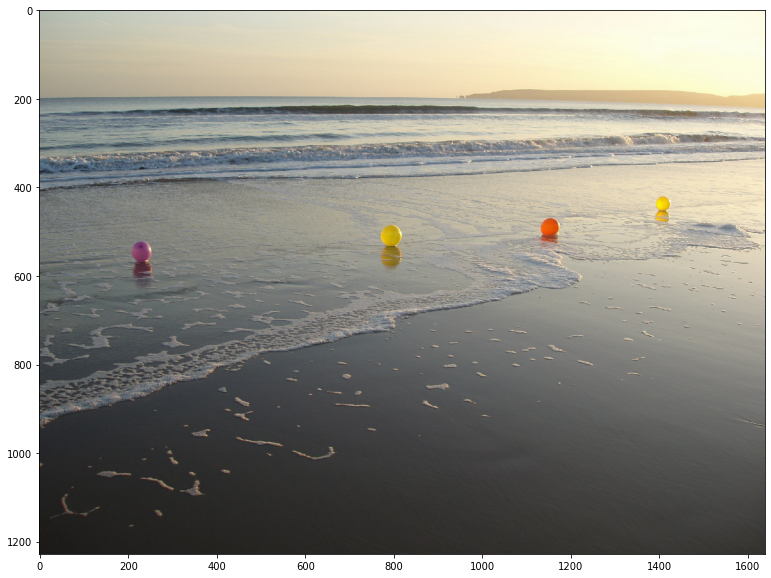

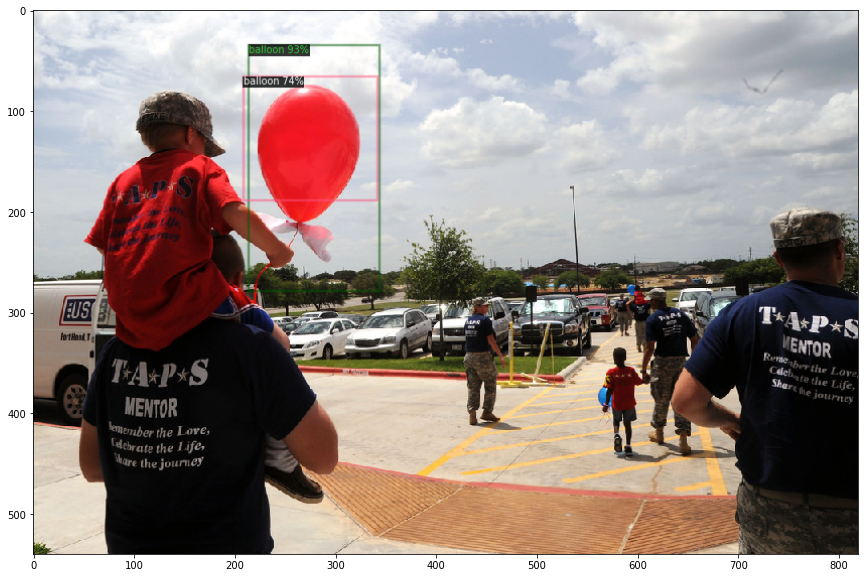

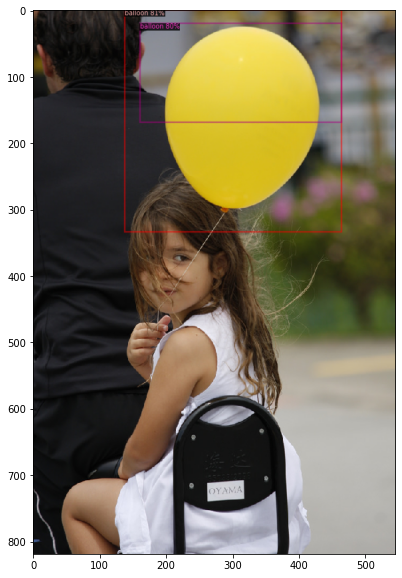

In [65]:
from detectron2.utils.visualizer import ColorMode
import random
# load weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
# Set training data-set path
cfg.DATASETS.TEST = ("balloon/val")
# Create predictor (model for inference)
predictor = DefaultPredictor(cfg)

dataset_dicts = get_dataset_dict(BALLOON_DIR+"val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (20, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [70]:
# save model configs
f = open('../configs/balloon_detection_config.yml', 'w')
f.write(cfg.dump())
f.close()

In [ ]:
# in order to add augmentations, you can extend default trainer class

In [71]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomRotation(angle=[90, 90]),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

In [73]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [ ]:
import torch
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file("../configs/faster_rcnn_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("balloon/train",)
cfg.DATASETS.TEST = ()   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = '../output/'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/31 12:32:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/31 12:32:52 d2.data.build]: Removed 0 images with no usable annotations. 61 images left.
[03/31 12:32:52 d2.data.build]: Using training sampler TrainingSampler
[03/31 12:32:52 d2.data.common]: Serializing 61 elements to byte tensors and concatenating them all ...
[03/31 12:32:52 d2.data.common]: Serialized dataset takes 0.04 MiB
WARNING [03/31 12:32:52 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[03/31 12:32:52 d2.engine.train_loop]: Starting training from iteration 0
[03/31 12:32:56 d2.utils.events]:  eta: 0:03:30  iter: 19  total_loss: 25.08  loss_cls: 0.9566  loss_box_reg: 0.5507  loss_rpn_cls: 22.44  loss_rpn_loc: 3.321  time: 0.2159  data_time: 0.0130  lr: 4.9953e-06  max_mem: 4413M
[03/31 12:33:01 d2.utils.events]:  eta: 0:03:29  iter: 39  total_loss: 1.489  loss_cls: 0.3797  loss_box_reg: 0.17  loss_rpn_cls: 0.3446  loss_rpn_loc: 0.1131  time: 0.2180  data_time: 0.0041  lr: 9.9902e-06  max_mem: 4413M
[03/31 12:33:05 d2.utils.events]:  eta: 0:03:24  iter: 59  total_loss: 0.7859  loss_cls: 0.3799  loss_box_reg: 0.08121  loss_rpn_cls: 0.2213  loss_rpn_loc: 0.02168  time: 0.2177  data_time: 0.0035  lr: 1.4985e-05  max_mem: 4413M
[03/31 12:33:10 d2.utils.events]:  eta: 0:03:20  iter: 79  total_loss: 0.8557  loss_cls: 0.3353  loss_box_reg: 0.1076  loss_rpn_cls: 0.2739  loss_rpn_loc: 0.05122  time: 0.2180  data_time: 0.0035  lr: 1.998e-05  max_mem: 4413M
[03/31 12:33:14 d2.uti